# Exercise 4: Simulate an Argo float trajectory

A typical dynamics of an Argo float is illustrated here:

http://www.argo.ucsd.edu/operation_park_profile.jpg

* Write a new kernel that defines the vertical dynamics of an Argo float particle
* Define an ArgoParticle, adding the appropriate variables

In [1]:
import math

def ArgoVerticalMovement(particle, fieldset, time, dt):
    # to modify !!
    vertical_speed = 0.10
    
    particle.age += dt
    particle.depth += vertical_speed * math.sin(2 * math.pi * time / (5 * 86400))
   

In [2]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, Variable
from datetime import timedelta
import numpy as np

# Load the GlobCurrent data in the Agulhas region from the example_data
filenames = {'U': "/Users/delandmeter/data/GlobCurrent_example_data/20*.nc",
             'V': "/Users/delandmeter/data/GlobCurrent_example_data/20*.nc"}
variables = {'U': 'eastward_eulerian_current_velocity',
             'V': 'northward_eulerian_current_velocity'}
dimensions = {'lat': 'lat', 'lon': 'lon', 'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
fieldset.mindepth = fieldset.U.depth[0]  # uppermost layer in the hydrodynamic data


In [3]:
class ArgoParticle(JITParticle):
    # to modify !!
    age = Variable('age', dtype=np.int32, initial=0.)

In [4]:
# Initiate one Argo float in the Agulhas Current
pset = ParticleSet(fieldset=fieldset, pclass=ArgoParticle, lon=[32], lat=[-31], depth=[0])

# combine Argo vertical movement kernel with built-in Advection kernel
kernels = ArgoVerticalMovement + pset.Kernel(AdvectionRK4)

# Now execute the kernels for 30 days, saving data every 30 minutes
pset.execute(kernels, runtime=timedelta(days=30), dt=timedelta(minutes=5), 
             output_file=pset.ParticleFile(name="argo_float", outputdt=timedelta(minutes=30)))

INFO: Compiled ArgoParticleArgoVerticalMovementAdvectionRK4 ==> /var/folders/h0/01fvrmn11qb62yjw7v1kn62r0000gq/T/parcels-503/6c7f97388709d727457f27b9604bc9e9.so


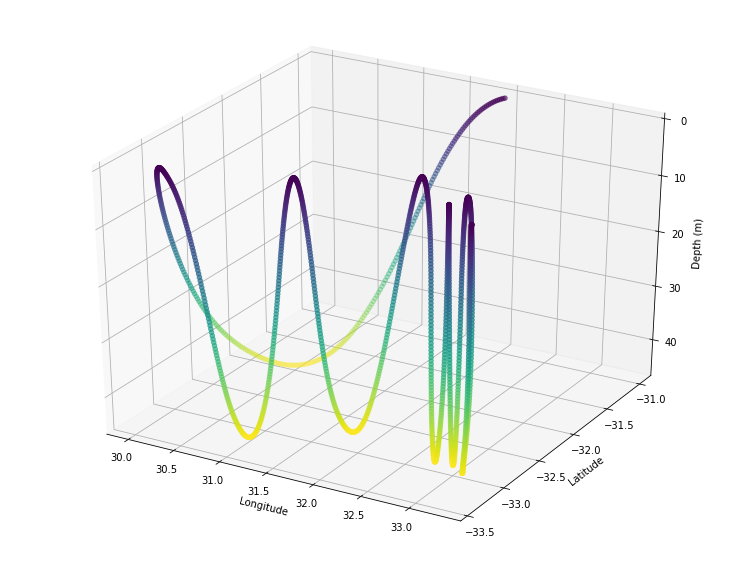

In [5]:
import netCDF4
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

nc = netCDF4.Dataset("argo_float.nc")
x = nc.variables["lon"][:]
y = nc.variables["lat"][:]
z = nc.variables["z"][:]
nc.close()

fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
cb = ax.scatter(x, y, z, c=z, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z),0)
plt.show()